# Setup

In [1]:
if not "wdSet" in globals():
    %cd -q ..
    wdSet = True

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [55]:
import os
import pandas as pd
import numpy as np
import glob
import tqdm
import asyncio
import ccxt
from tqdm.auto import tqdm

import matplotlib as mpl
from matplotlib import pyplot as plt

from datetime import datetime, timedelta, timezone
from pprint import pprint

# Download Data

In [4]:
exchange = ccxt.bitstamp({"enableRateLimit": True, "rateLimit": 85})

In [5]:
from core.data.cdd import get_historical_data, get_crypto_dataset

get_crypto_dataset(
    exchange,
    symbol="BTC/USD",
    timeframe="1h",
    start_date=datetime(2015, 1, 1),
    max_per_page=1000,
)

,datetime,open,high,low,close,volume
0,2015-01-01 01:00:00,314.70,315.80,314.34,315.20,23.948645
1,2015-01-01 02:00:00,315.38,317.11,315.12,315.70,91.662967
2,2015-01-01 03:00:00,315.67,316.27,314.34,316.27,33.067211
3,2015-01-01 04:00:00,316.01,318.25,315.00,316.64,286.291773
4,2015-01-01 05:00:00,316.64,317.30,314.41,315.63,178.913984
...,...,...,...,...,...,...
55051,2021-04-13 03:00:00,60714.00,61198.00,60573.81,61008.76,130.598719
55052,2021-04-13 04:00:00,61050.00,62741.44,61022.84,62657.21,740.382379
55053,2021-04-13 05:00:00,62651.75,63199.44,62260.41,62886.44,312.124843
55054,2021-04-13 06:00:00,62881.21,63053.60,62434.34,62740.92,284.760349


In [6]:
get_crypto_dataset(
    exchange,
    symbol="ETH/USD",
    timeframe="1h",
    start_date=datetime(2017, 1, 1),
    max_per_page=1000,
)

get_crypto_dataset(
    exchange,
    symbol="LTC/USD",
    timeframe="1h",
    start_date=datetime(2017, 1, 1),
    max_per_page=1000,
)

get_crypto_dataset(
    exchange,
    symbol="ETH/BTC",
    timeframe="1h",
    start_date=datetime(2017, 1, 1),
    max_per_page=1000,
)

get_crypto_dataset(
    exchange,
    symbol="LTC/BTC",
    timeframe="1h",
    start_date=datetime(2017, 1, 1),
    max_per_page=1000,
)


get_crypto_dataset(
    exchange,
    symbol="XRP/USD",
    timeframe="1h",
    start_date=datetime(2017, 1, 1),
    max_per_page=1000,
)

get_crypto_dataset(
    exchange,
    symbol="XRP/BTC",
    timeframe="1h",
    start_date=datetime(2017, 1, 1),
    max_per_page=1000,
)

,datetime,open,high,low,close,volume
0,2017-02-10 08:00:00,0.000006,0.000006,0.000006,0.000006,3.000000e+03
1,2017-02-10 09:00:00,0.000006,0.000006,0.000006,0.000006,9.912346e+02
2,2017-02-10 10:00:00,0.000006,0.000006,0.000006,0.000006,0.000000e+00
3,2017-02-10 11:00:00,0.000006,0.000006,0.000006,0.000006,0.000000e+00
4,2017-02-10 12:00:00,0.000006,0.000006,0.000006,0.000006,0.000000e+00
...,...,...,...,...,...,...
36542,2021-04-13 03:00:00,0.000026,0.000027,0.000026,0.000027,1.708757e+06
36543,2021-04-13 04:00:00,0.000027,0.000027,0.000025,0.000026,2.823741e+06
36544,2021-04-13 05:00:00,0.000025,0.000026,0.000025,0.000025,1.219312e+06
36545,2021-04-13 06:00:00,0.000026,0.000027,0.000025,0.000026,9.895101e+05


# Datast

In [7]:
from torch.utils.data import Dataset

class StockDataset(Dataset):
    def __init__(
        self,
        data,
        sequence_length,
        target="close",
        features=None
    ):
        self.data = self._preprocess_data(data)
        self.features = features or list(self.data.select_dtypes("number").columns)
        self.target = target
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length + 1

    def __getitem__(self, index):
        index = (index + len(self)) % len(self)
        target = self.data[self.target][index : index + self.sequence_length].values
        center, scale = np.mean(target), np.std(target)
        normalized = (target - center) / (scale + 1e-8)
        return normalized, (center, scale), index

    def _preprocess_data(self, data):
        assert "time_idx" in data.columns
        return type(self).fill_missing_time_idx(data)

    @staticmethod
    def fill_missing_time_idx(data):
        time = data.time_idx
        start, end = time.min(), time.max()
        missing = start + np.nonzero(~np.isin(np.arange(start, end + 1), time))[0]
        missing_df = pd.DataFrame({"time_idx": missing})
        data = (
            data.merge(missing_df, how="outer", on="time_idx")
            .sort_values("time_idx")
            .fillna(method="ffill")
        )
        return data

In [8]:
from core.data.preprocess import process_common, process_dtypes, add_time_idx

df = get_crypto_dataset(
    exchange,
    symbol="BTC/USD",
    timeframe="1h",
    start_date=datetime(2015, 1, 1),
    max_per_page=1000,
)

data = process_dtypes(df)
data = add_time_idx(data)

In [9]:
data

,datetime,open,high,low,close,volume,time_idx
0,2015-01-01 01:00:00,314.70,315.80,314.34,315.20,23.948645,131497
1,2015-01-01 02:00:00,315.38,317.11,315.12,315.70,91.662967,131498
2,2015-01-01 03:00:00,315.67,316.27,314.34,316.27,33.067211,131499
3,2015-01-01 04:00:00,316.01,318.25,315.00,316.64,286.291773,131500
4,2015-01-01 05:00:00,316.64,317.30,314.41,315.63,178.913984,131501
...,...,...,...,...,...,...,...
55051,2021-04-13 03:00:00,60714.00,61198.00,60573.81,61008.76,130.598719,186555
55052,2021-04-13 04:00:00,61050.00,62741.44,61022.84,62657.21,740.382379,186556
55053,2021-04-13 05:00:00,62651.75,63199.44,62260.41,62886.44,312.124843,186557
55054,2021-04-13 06:00:00,62881.21,63053.60,62434.34,62740.92,284.760349,186558


In [10]:
dataset = StockDataset(data, sequence_length=256)

# Train

In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from core.nn.vae import VanillaVAE
from core.nn.lit import LitVAE

In [116]:
sequence_length = 256
val_ratio = 0.2
val_size = int(len(data) * val_ratio)

train, val = StockDataset(data[:-val_size], sequence_length), StockDataset(
    data[-val_size:], sequence_length
)

In [ ]:
import pytorch_lightning as pl

experiment_name = "firsty"

latent_dim = 32
kl_beta = 5
learning_rate = 1e-4
batch_size = 64
num_workers = 4

num_sanity_val_steps = 10
max_epochs = 40


train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=num_workers)


checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="loss/val",
    dirpath=f"checkpoints/{experiment_name}",
    filename="masknet-{epoch:02d}-{loss/val:.2f}",
    save_top_k=3,
    mode="min",
)
logger = pl.loggers.TensorBoardLogger("logs", name=experiment_name)

model = LitVAE(latent_dim, kl_beta, learning_rate)

num_gpus = torch.cuda.device_count()
trainer = pl.Trainer(
    callbacks=[checkpoint_callback],
    logger=logger,
    gpus=num_gpus,
    num_sanity_val_steps=num_sanity_val_steps,
    max_epochs=max_epochs,
    flush_logs_every_n_steps=10,
    progress_bar_refresh_rate=5,
    weights_summary="full",
)

trainer.fit(model, train_loader, val_loader)

/home/nsarang/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: You requested multiple GPUs but did not specify a backend, e.g. `Trainer(accelerator="dp"|"ddp"|"ddp2")`. Setting `accelerator="ddp_spawn"` for you.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


# Test

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [5]:
from train import load_datasets

train, val = load_datasets(["BTC/USD"], "1h", 0.15, 256)

BTC/USD 49564


In [6]:
from core.nn.lit import LitVAE

model = LitVAE.load_from_checkpoint("checkpoints/07-low-beta/masknet-epoch=32-loss/val=0.12.ckpt")
model.eval()
model.freeze();

In [9]:
train_loader = DataLoader(train, batch_size=64, shuffle=False)
val_loader = DataLoader(val, batch_size=64, shuffle=False)

In [32]:
train_embeddings = []
val_embeddings = []

In [33]:
for batch in tqdm(train_loader):
    mu, log_var = model.vae.encode(batch["x"])
    vec = torch.cat((mu, log_var), dim=1)
    train_embeddings.append(vec)

  0%|          | 0/655 [00:00<?, ?it/s]

In [34]:
for batch in tqdm(val_loader):
    mu, log_var = model.vae.encode(batch["x"])
    vec = torch.cat((mu, log_var), dim=1)
    val_embeddings.append(vec)

  0%|          | 0/113 [00:00<?, ?it/s]

In [35]:
train_embeddings = torch.cat(train_embeddings)
val_embeddings = torch.cat(val_embeddings)

In [37]:
train_embeddings.shape

torch.Size([41881, 64])

In [362]:
index = -1
k = 5

values, indices = torch.topk(
    torch.cdist(train_embeddings, val_embeddings[None, index], p=1)[:, 0],
    k,
    largest=False,
)

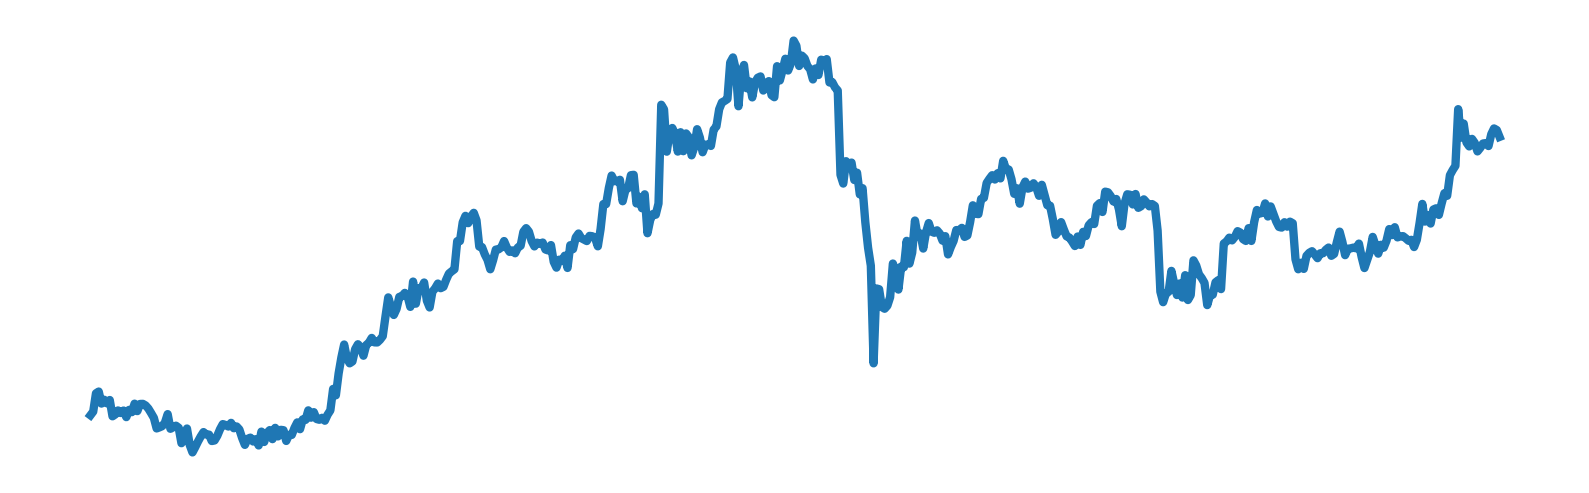

In [388]:
plt.figure(figsize=(10, 3))
plt.axis("off")
v = train.datasets[0].data.iloc[indices[0].item()+256:indices[0].item()+256+512]["close"].values
plt.plot(v, linewidth=3)

In [398]:
scales

('scales', (422.11421875, 3.069521952136592))

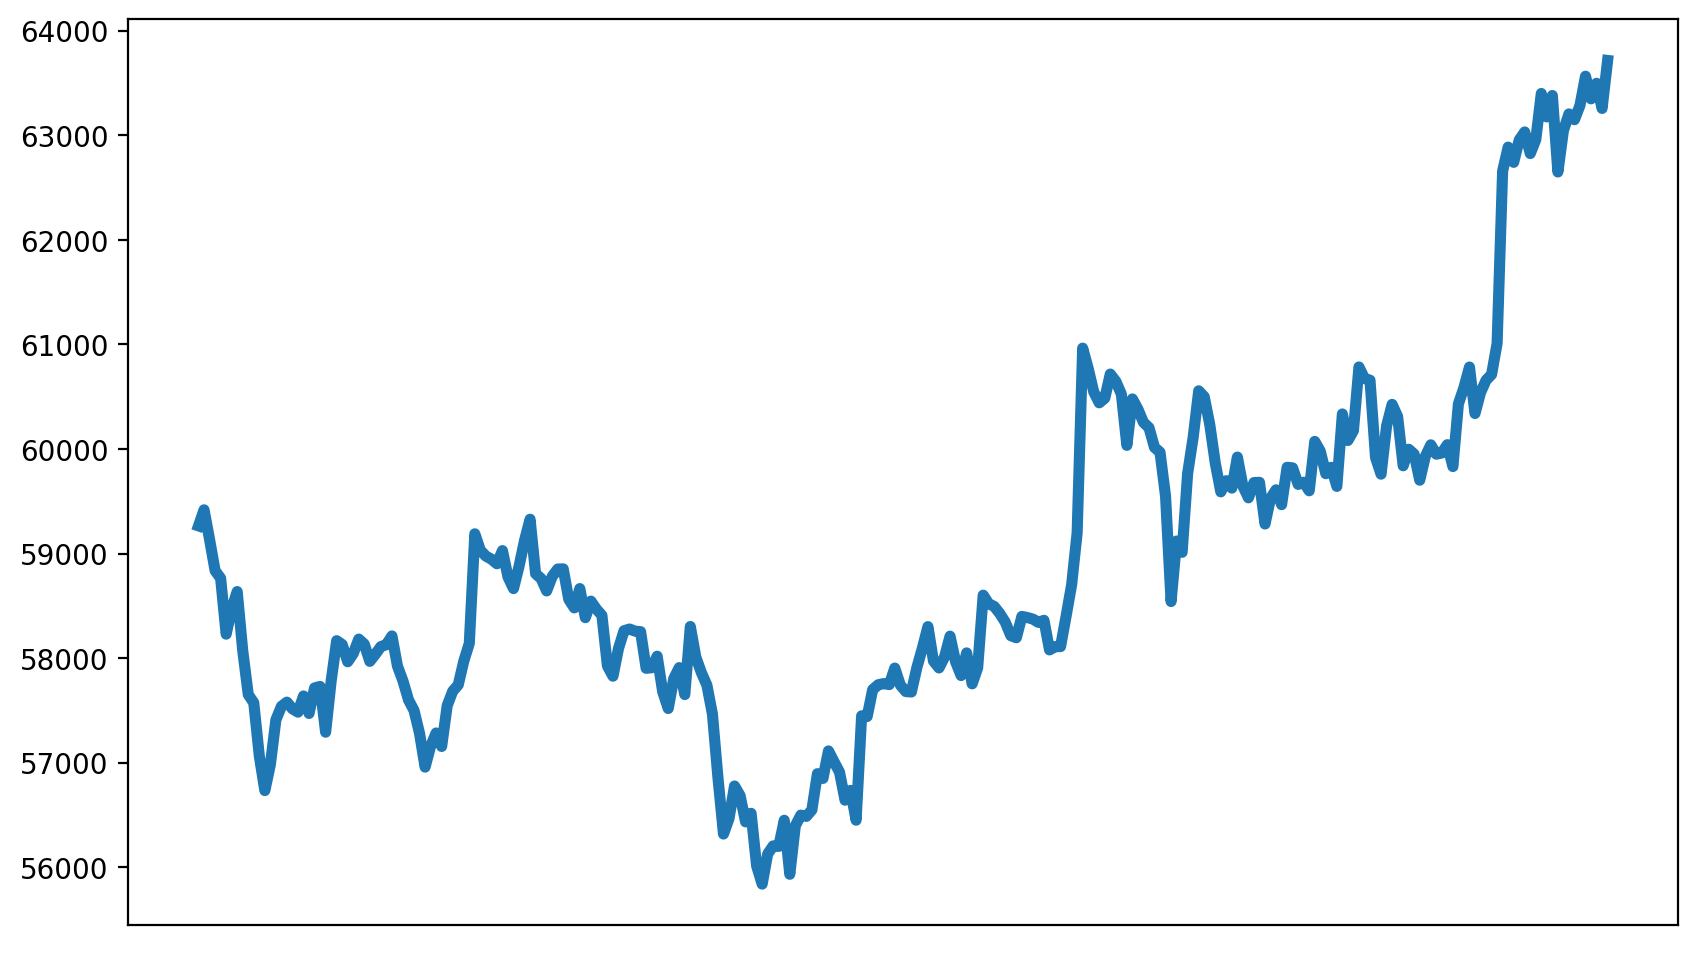

In [405]:
fig = plt.figure(figsize=(10, 6))
v, scales, _ = train[indices[0].item()].values()
v, scales, _ = val[index].values()

plt.plot(((v[0] * scales[1])+scales[0]), linewidth=4)
fig.axes[0].get_xaxis().set_visible(False)

# plt.plot(val[index]["x"][0], linewidth=4)

In [340]:
def evaluate(seq_len, prediction_window, embed_cmp, pred_error_cmp):
    errors = []
    pred_target = []
    matches = []
    for i in range(0, len(val_embeddings) - prediction_window, seq_len // 4):
        target_vec = val_embeddings[None, i]
        indices = embed_cmp(train_embeddings, target_vec)
        
        j = indices[0].item()
        d = train[j]
        m_train = d["x"][0]
        tr_scales = d["scales"]
        
        pred = train.datasets[0].data.iloc[j + seq_len : j + seq_len + prediction_window]["close"].values
        pred = (pred - tr_scales[0]) / (tr_scales[1] + 1e-8)
        
        j2 = indices[1].item()
        d2 = train[j2]
        m_train2 = d2["x"][0]
        tr_scales2 = d2["scales"]
        pred2 = train.datasets[0].data.iloc[j2 + seq_len : j2 + seq_len + prediction_window]["close"].values
        pred2 = (pred2 - tr_scales2[0]) / (tr_scales2[1] + 1e-8)
        
        pred = (pred+pred2)/2
        
        d = val[i]
        m_val = d["x"][0]
        scales = d["scales"]
        target = val.datasets[0].data.iloc[i + seq_len : i + seq_len + prediction_window]["close"].values
        target = (target - scales[0]) / (scales[1] + 1e-8)
        
        error = pred_error_cmp(pred, target)
        errors.append(error)
        pred_target.append((pred, target))
        matches.append((m_train, m_val))
    errors = np.array(errors)
    return matches, pred_target, errors, errors.mean(), errors.std()

In [341]:
cdist_w_cmp = lambda x, y: torch.topk(
    torch.cdist(x[:, :32], y[:, :32], p=1)[:, 0] + torch.cdist(x[:, 32:], y[:, 32:], p=1)[:, 0] / 2,
    5,
    largest=False,
)[1]

cdist_cmp = lambda x, y: torch.topk(
    torch.cdist(x, y, p=1)[:, 0],
    5,
    largest=False,
)[1]

cdist2_cmp = lambda x, y: torch.topk(
    torch.cdist(x, y, p=2)[:, 0],
    5,
    largest=False,
)[1]

cosine_cmp = lambda x, y: torch.topk(
    nn.CosineSimilarity()(x, y),
    5,
    largest=True,
)[1]

cosine_w_cmp = lambda x, y: torch.topk(
    nn.CosineSimilarity()(x[:, :32], y[:, :32]) + nn.CosineSimilarity()(x[:, 32:], y[:, 32:]) / 2,
    5,
    largest=True,
)[1]

In [406]:
pred_mae_cmp = lambda x, y: np.abs((x - y)).mean()

In [460]:
matches, pred_target, errors, mean, std = evaluate(256, 256, cosine_cmp, pred_mae_cmp)
mean, std

(2.743567429743908, 2.8866120689115125)

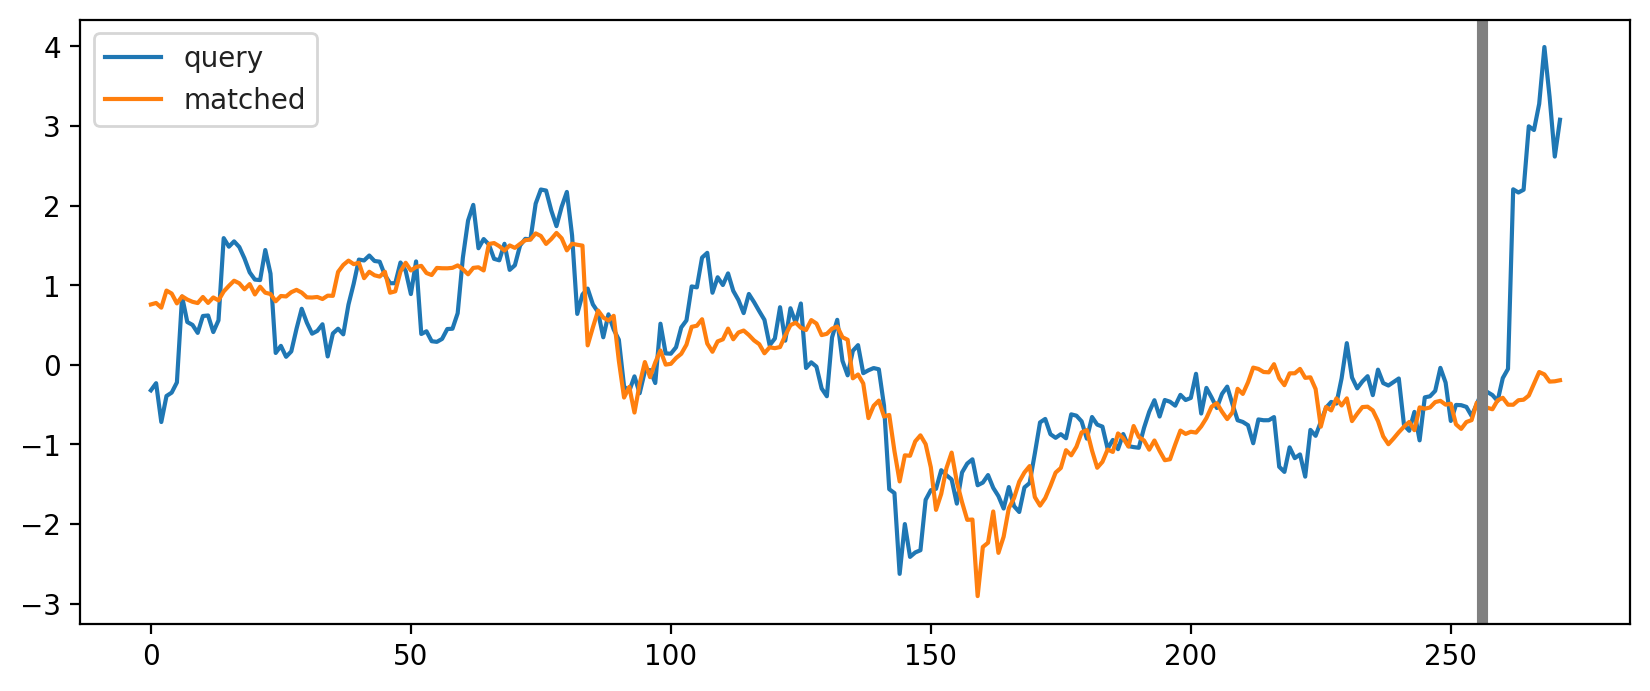

In [456]:
p_index = 12
p, t = pred_target[p_index]
p0, t0 = matches[p_index]

p = np.concatenate((p0, p))
t = np.concatenate((t0, t))

plt.figure(figsize=(10, 4))
plt.plot(t, label="query")
plt.plot(p, label="matched")
plt.axvline(x=len(p0), linewidth=4, color="gray")
plt.legend()

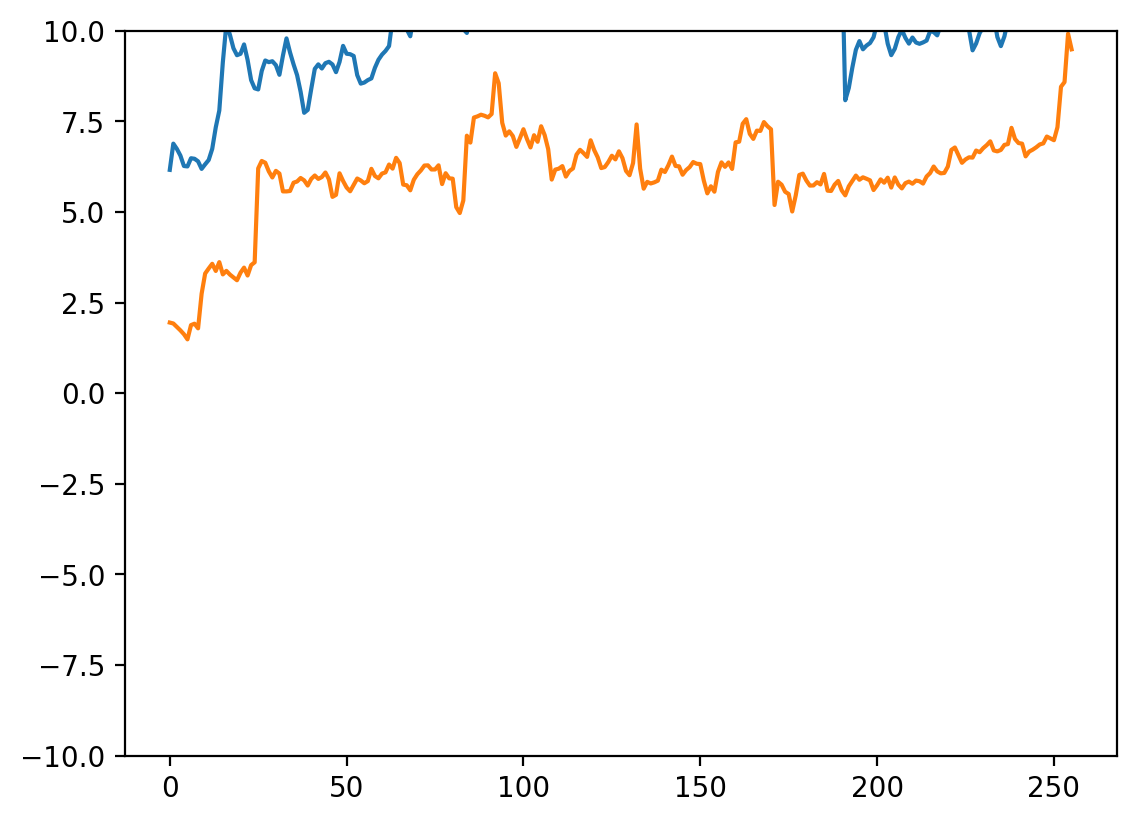

In [361]:
plt.ylim(-10, 10)
plt.plot(pred_target[42][0])
plt.plot(pred_target[42][1])